In [1]:
import pyspark
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('nyc_taxi_notebook_04') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/27 20:19:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.uiWebUrl

'http://spark-medium.europe-southwest1-a.c.de-zoomcamp-jhigaki-course.internal:4040'

In [4]:
df_yellow = spark.read\
    .parquet(f'tmp-data/pq/yellow/*/*')\
    .withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')
    


In [5]:
df_green = spark.read\
    .parquet(f'tmp-data/pq/green/*/*')\
    .withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime')
    


In [6]:
from pyspark.sql import functions as F


In [7]:
def get_metrics_per_hour_pickup_location(df):
    return df.filter(\
        (F.col('pickup_datetime') >= '2019-01-01 00:00:00')\
        &(F.col('pickup_datetime') < '2020-01-01 00:00:00'))\
        .withColumn('pickup_hour', F.date_trunc('hour', 'pickup_datetime'))\
        .select('pickup_hour', 'PULocationID', 'DOLocationID','passenger_count', 'trip_distance','total_amount')\
        .groupBy('pickup_hour', 'PULocationID')\
        .agg(\
            F.sum('total_amount').alias('total_amount'),\
            F.sum('passenger_count').alias('passenger_count'),\
            F.sum('trip_distance').alias('trip_distance'),\
            F.count('*').alias('trip_count')\
        )\
        .orderBy('pickup_hour', 'PULocationID')
    

In [8]:
df_yellow_metrics = get_metrics_per_hour_pickup_location(df_yellow)\
    .withColumn('service_type', F.lit('yelllow'))
df_green_metrics = get_metrics_per_hour_pickup_location(df_green)\
    .withColumn('service_type', F.lit('green'))

In [9]:
df_yellow_metrics.show(100)

+-------------------+------------+------------------+---------------+------------------+----------+------------+
|        pickup_hour|PULocationID|      total_amount|passenger_count|     trip_distance|trip_count|service_type|
+-------------------+------------+------------------+---------------+------------------+----------+------------+
|2019-01-01 00:00:00|           4|            731.72|           73.0|            136.87|        49|     yelllow|
|2019-01-01 00:00:00|           7|            332.61|           31.0|             74.12|        25|     yelllow|
|2019-01-01 00:00:00|          10|              28.6|            2.0|              6.04|         2|     yelllow|
|2019-01-01 00:00:00|          11|              18.6|            3.0|              3.59|         2|     yelllow|
|2019-01-01 00:00:00|          12|             55.55|           13.0|12.440000000000001|         4|     yelllow|
|2019-01-01 00:00:00|          13|1134.1199999999997|          108.0|            244.72|        

 🔝
 
## Metrics Generated

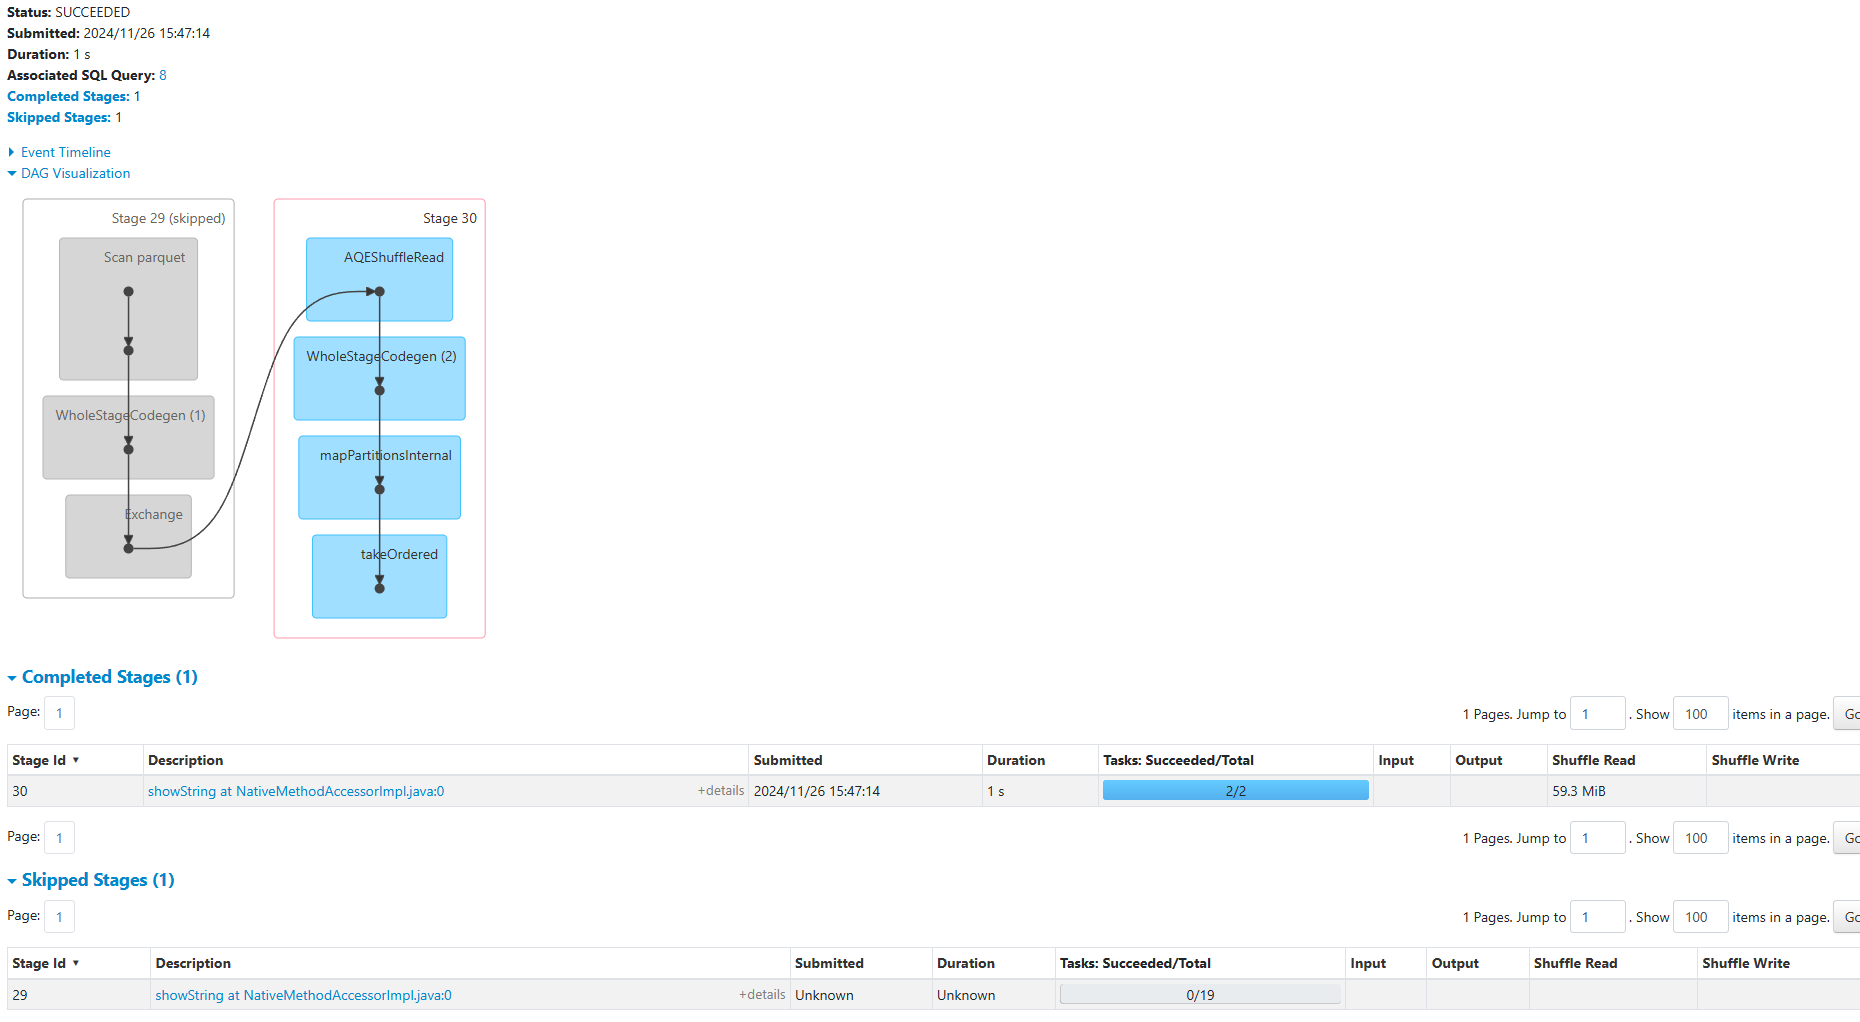

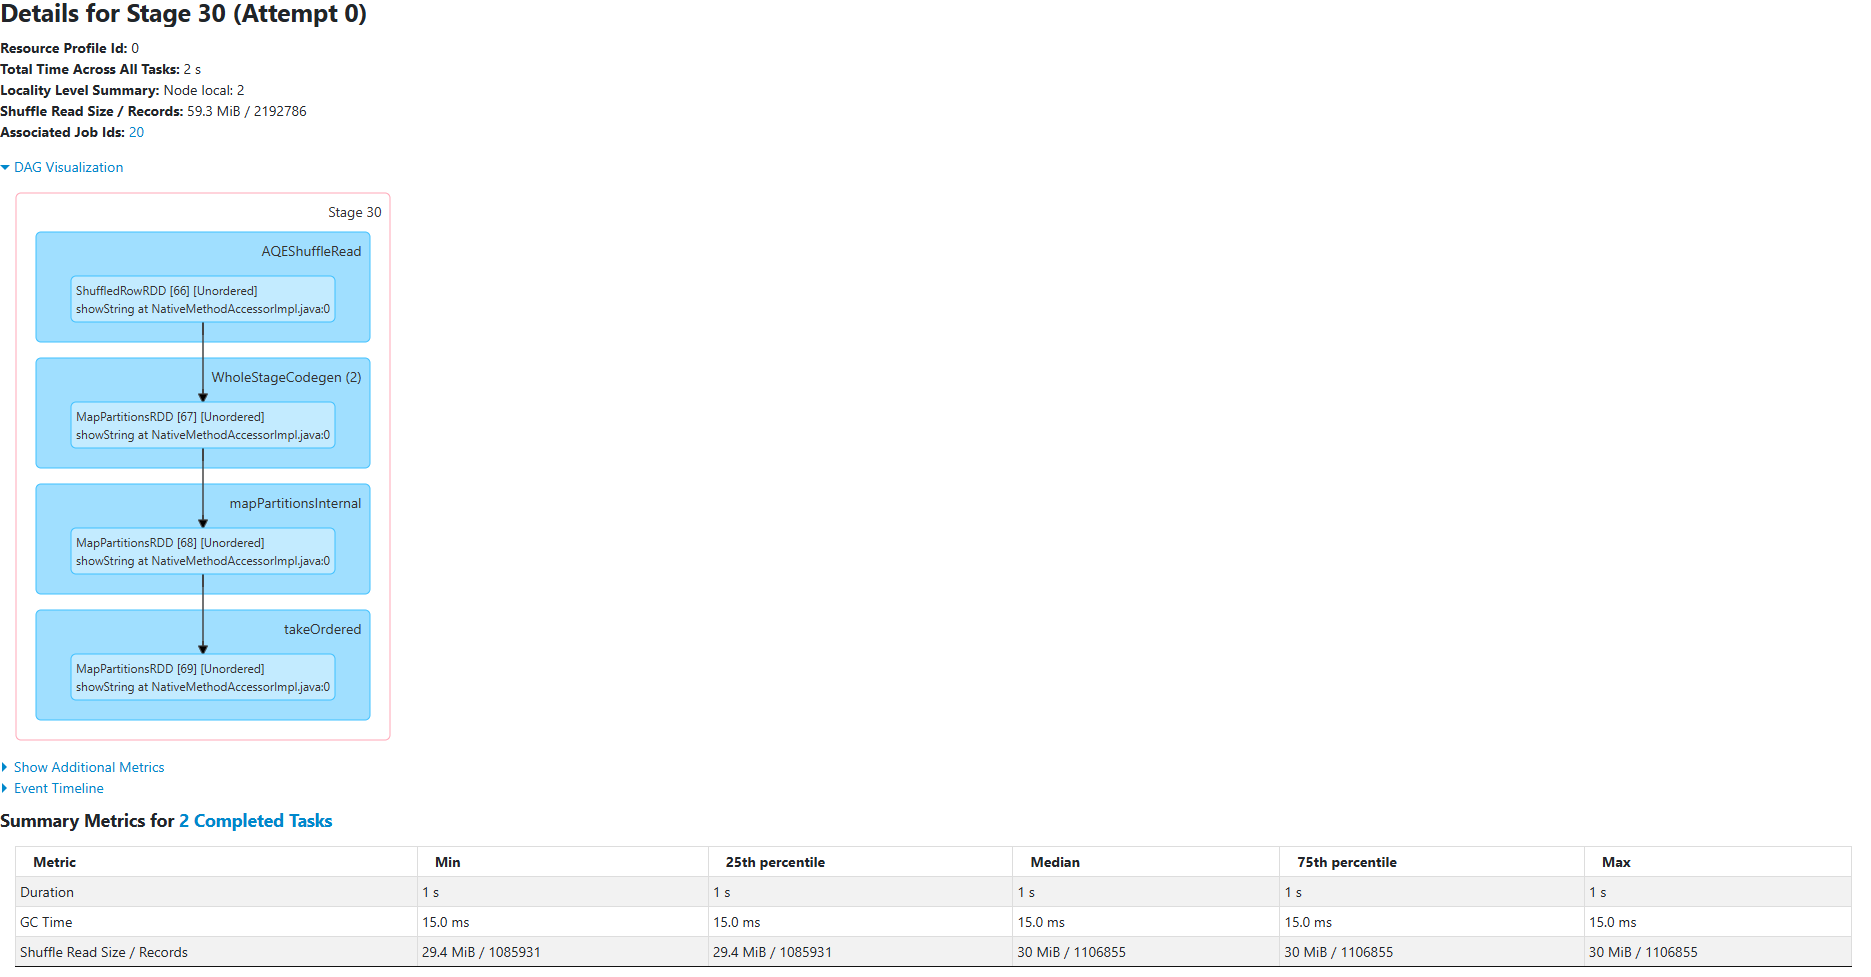

Save them each to a parquet file

In [10]:
df_yellow_metrics.\
    write.parquet(f'tmp-data/pq/reports/yellow/no_repartition_specified/')

## No Repartition

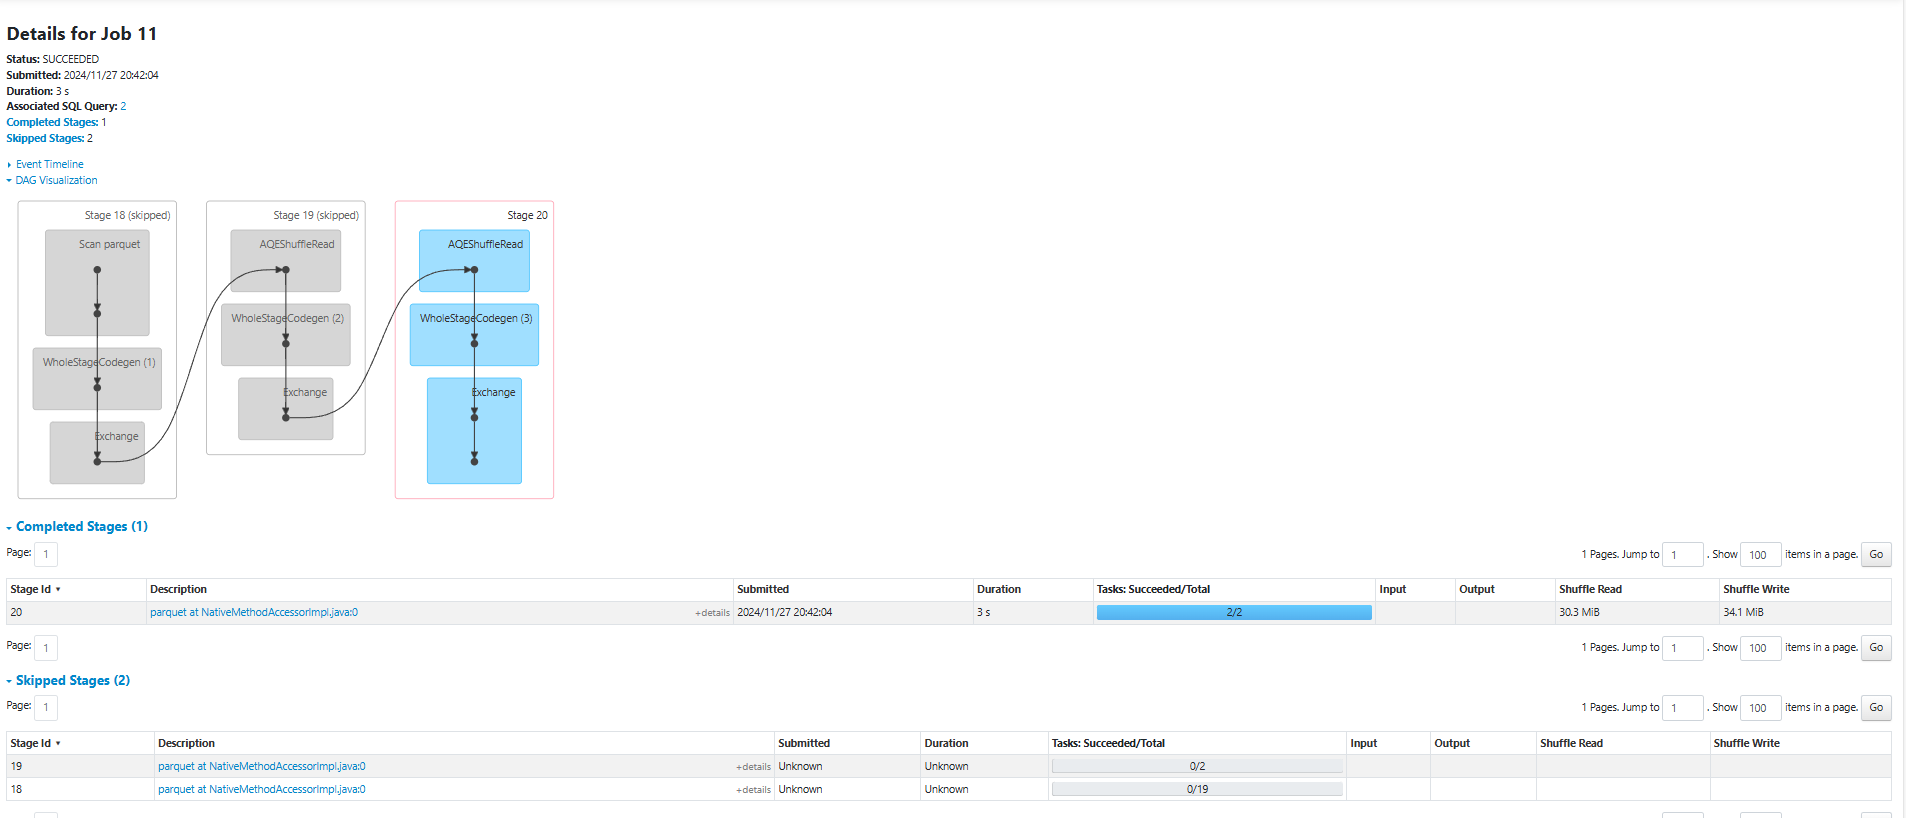

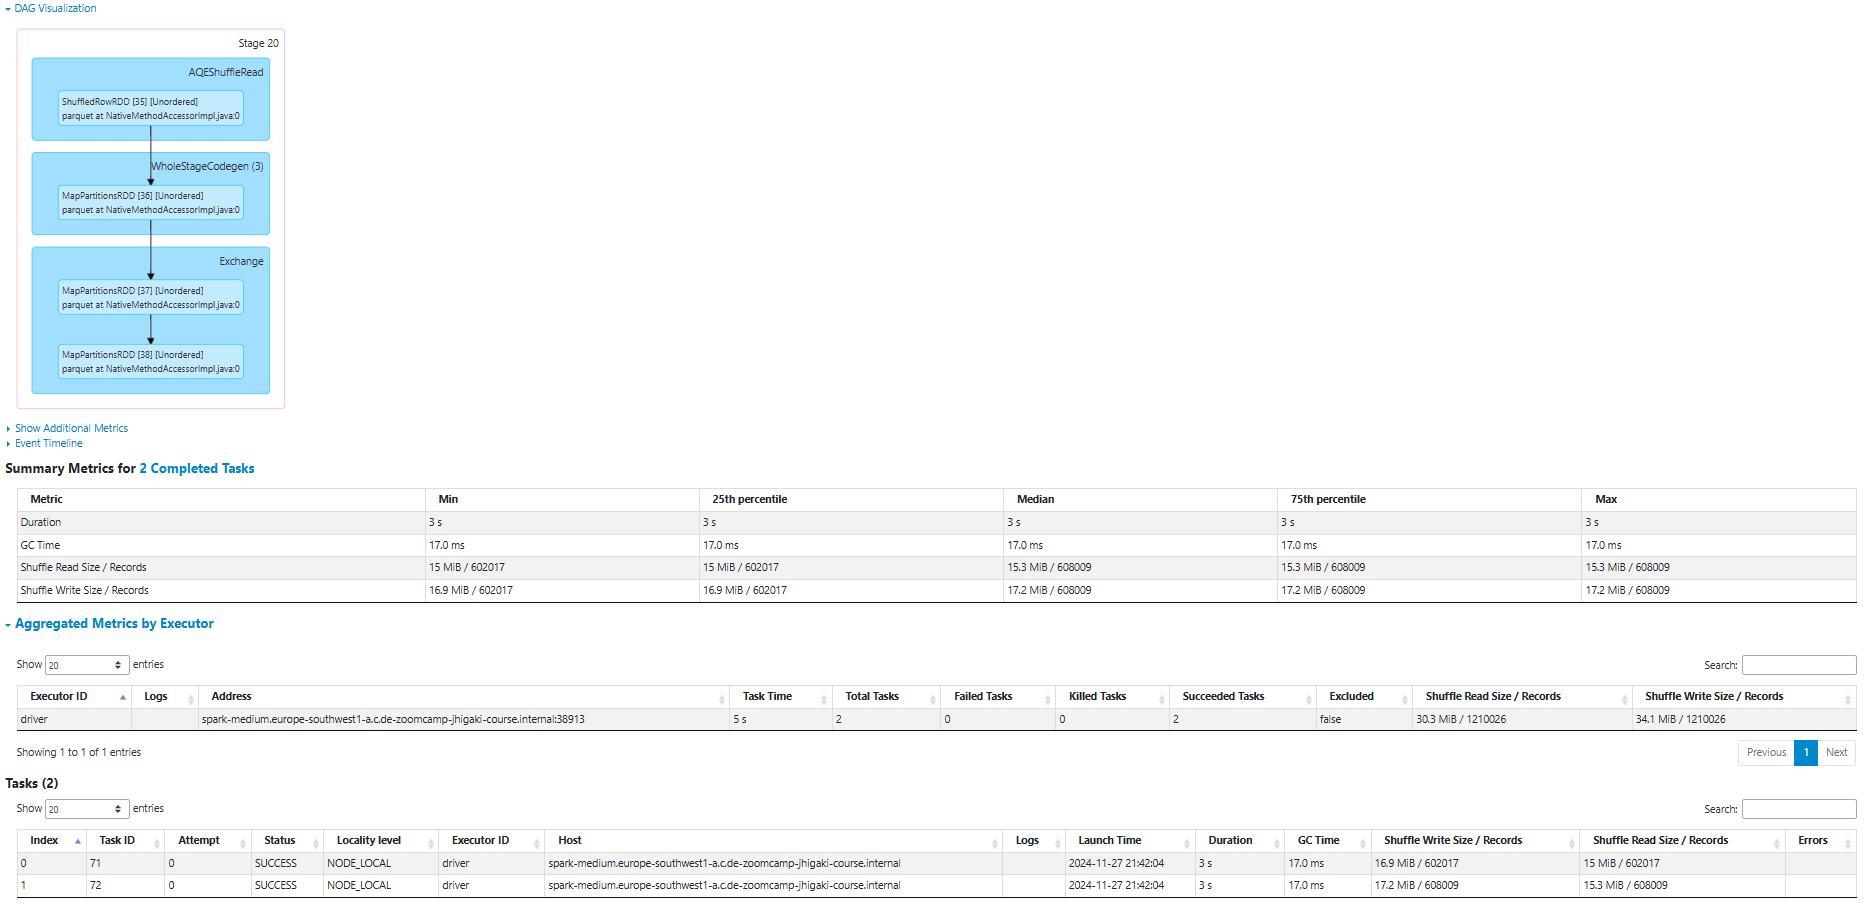

In [11]:
df_yellow_metrics.\
    repartition(10).\
    write.parquet(f'tmp-data/pq/reports/yellow/repartition_10/')

## Repartition 10

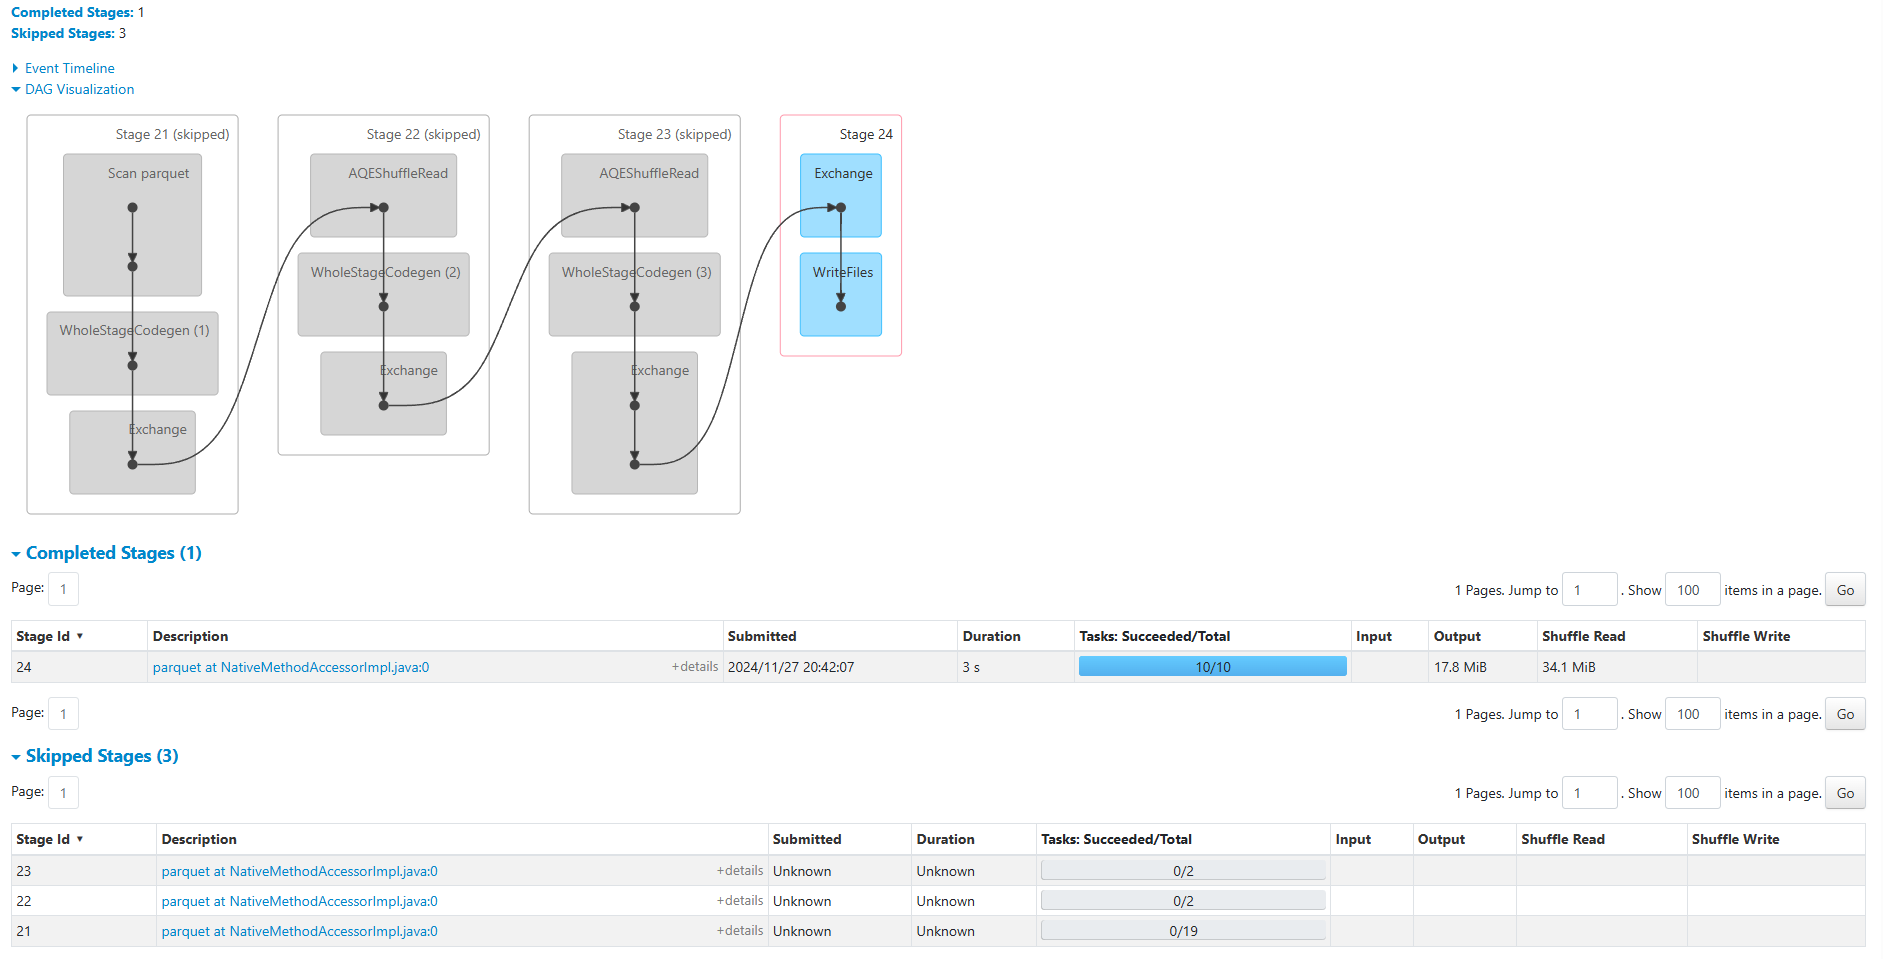

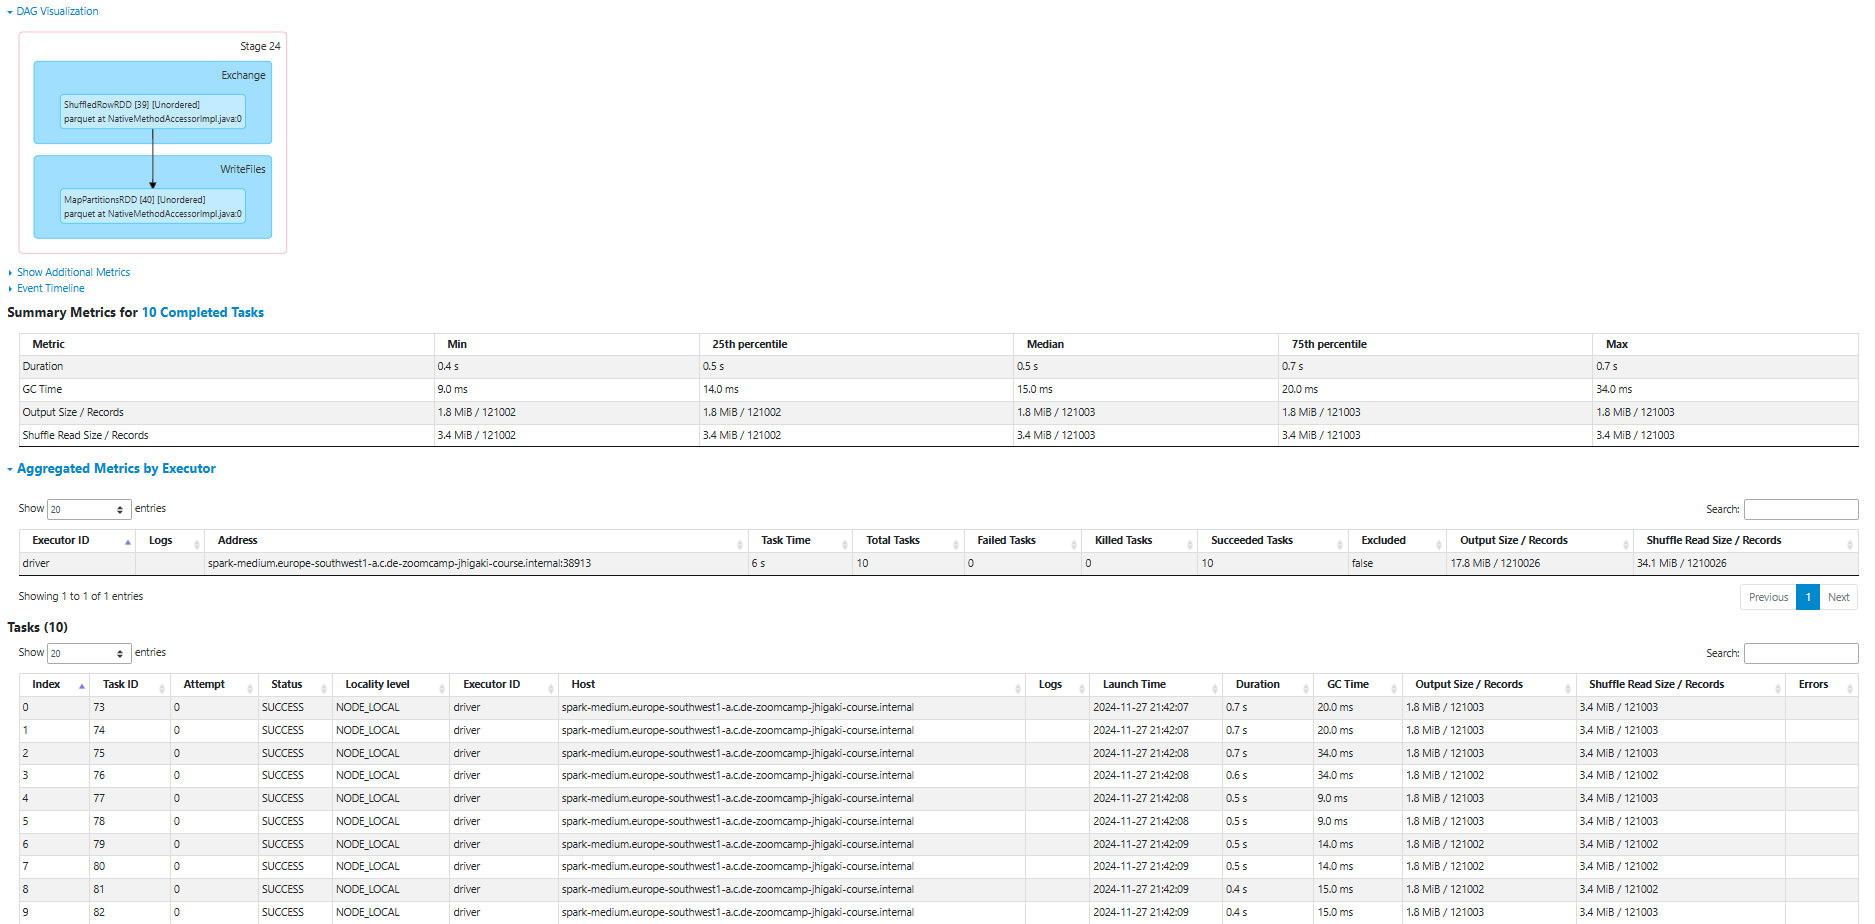

```bash
tmp-data/pq/reports/yellow/:
total 8.0K
4.0K no_repartition_specified  4.0K repartition_10

tmp-data/pq/reports/yellow/no_repartition_specified:
total 15M
   0 _SUCCESS  
   7.6M part-00000-035440ea-e861-4b06-a5eb-2eb0dd1386b0-c000.snappy.parquet
   7.5M part-00001-035440ea-e861-4b06-a5eb-2eb0dd1386b0-c000.snappy.parquet

tmp-data/pq/reports/yellow/repartition_10:
total 18M
   0 _SUCCESS                                                             
   1.8M part-00005-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet
   1.8M part-00000-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet  
   1.8M part-00006-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet
   1.8M part-00001-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet  
   1.8M part-00007-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet
   1.8M part-00002-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet  
   1.8M part-00008-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet
   1.8M part-00003-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet  
   1.8M part-00009-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet
   1.8M part-00004-6c129db3-5beb-41a4-8e75-4b937e52e68b-c000.snappy.parquet
```

Repartition was done just for testing
Let's save each

In [13]:
df_yellow_metrics.\
    coalesce(1).\
    write.parquet(f'tmp-data/pq/reports/yellow/')

```bash
tmp-data/pq/reports/yellow/:
total 16M
  0 _SUCCESS  
  16M part-00000-593db24c-1135-42a2-9c03-9199d440be58-c000.snappy.parquet
```

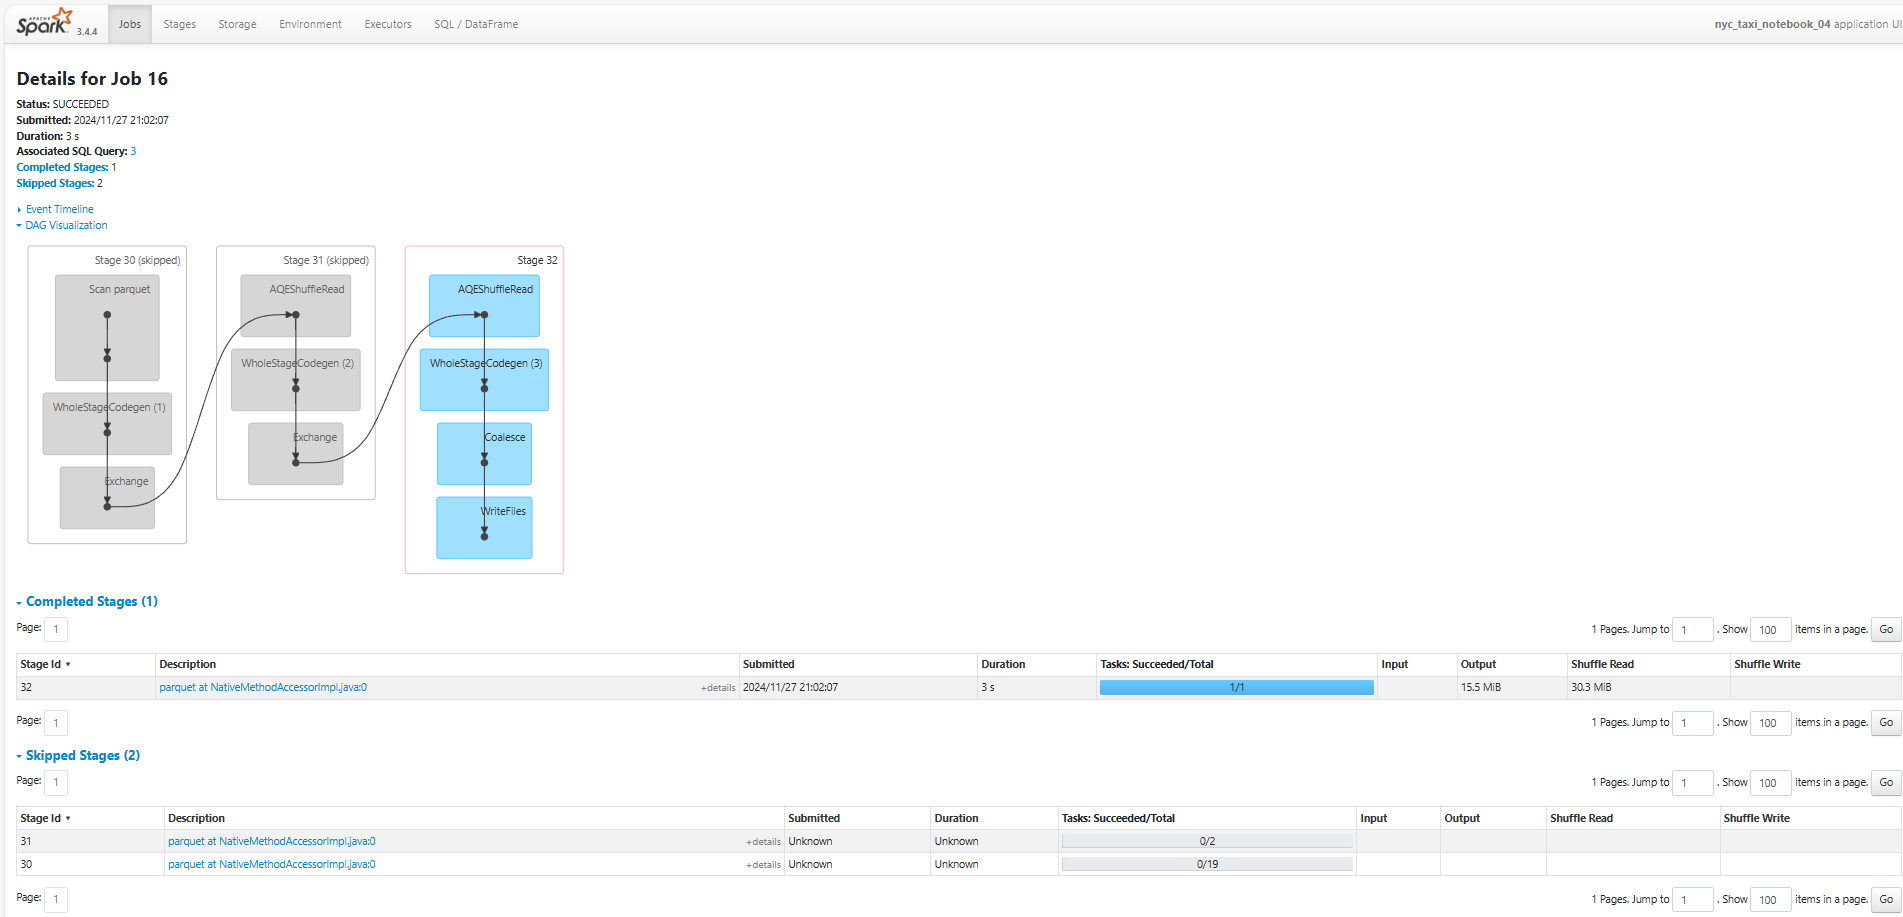

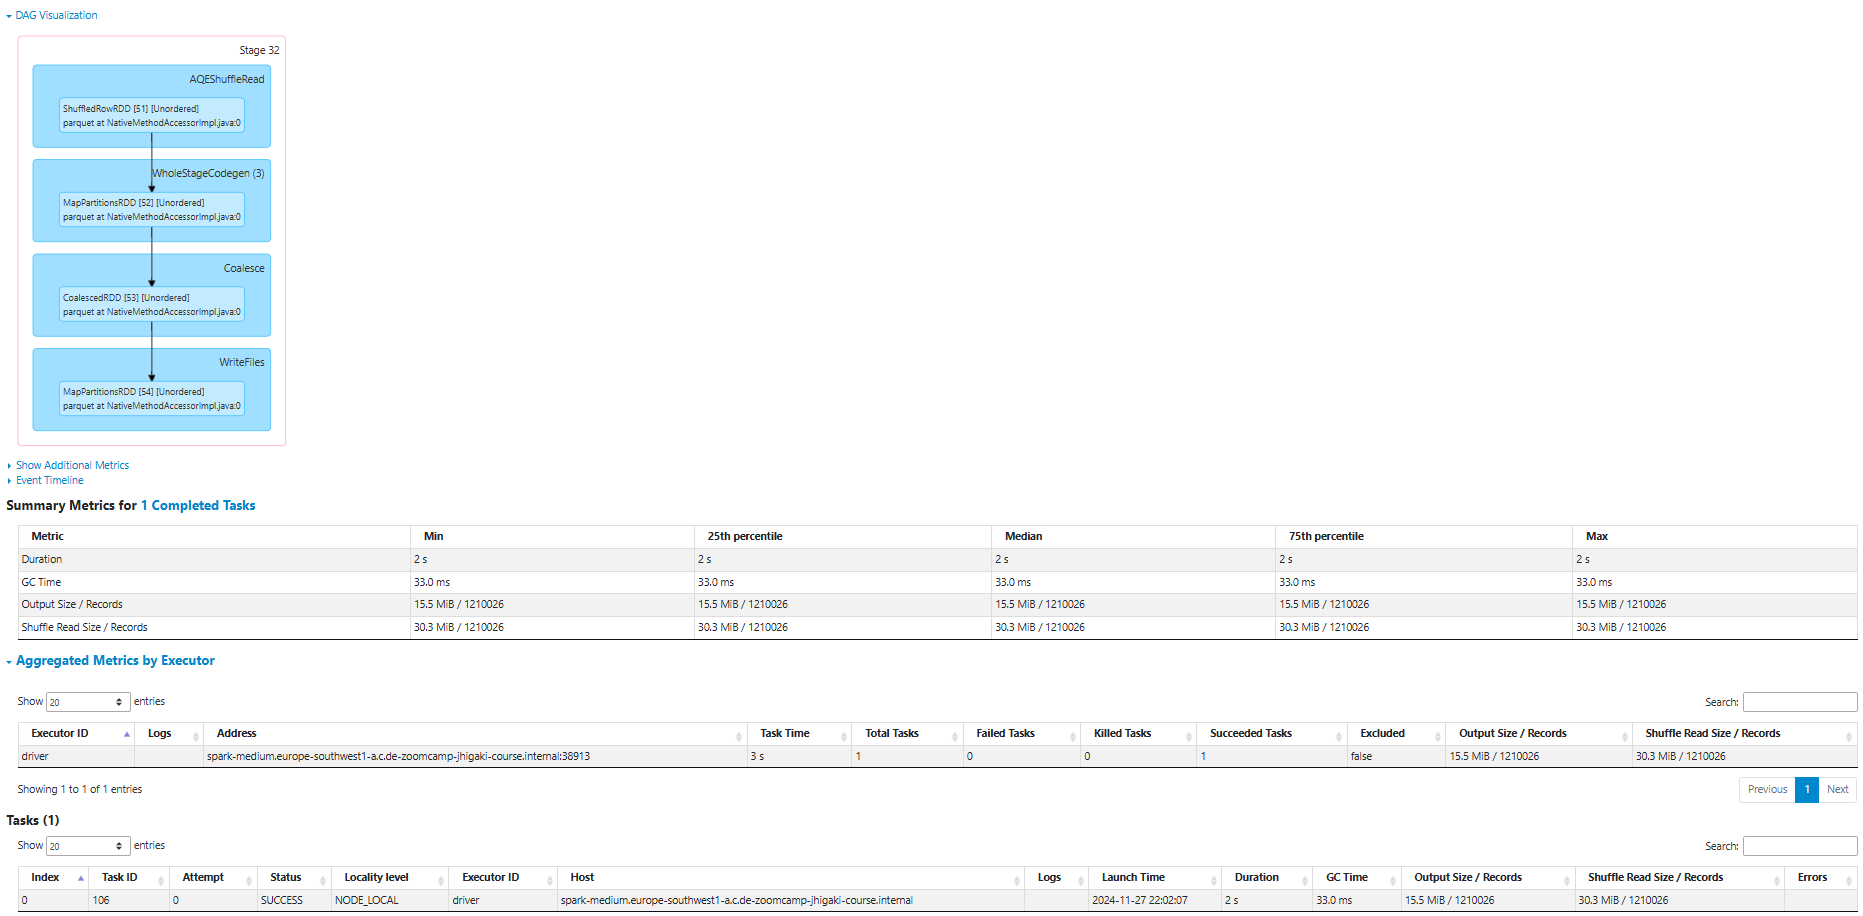

In [14]:
df_green_metrics.\
    coalesce(1).\
    write.parquet(f'tmp-data/pq/reports/green/')

In [ ]:
unionm
reduce
map 
reduce
report